In [3]:
!pip install torchsummary
!pip install torchview

In [4]:
import os
import numpy as np
import pandas as pd 


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init 
from torchview import draw_graph
from torchsummary import summary
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
input_dir = '/kaggle/input/salicon/images/images/images/train'
output_dir = '/kaggle/input/salicon/maps/maps/train'
input_dir_val = '/kaggle/input/salicon/images/images/images/val'
output_dir_val = '/kaggle/input/salicon/maps/maps/val'
# input_dir_CAT2000 = 'kaggle/input/'

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))

        assert len(self.input_files) == len(self.output_files), "Number of input images does not match number of output images."

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_img_name = os.path.join(self.input_dir, self.input_files[idx])
        output_img_name = os.path.join(self.output_dir, self.output_files[idx])
#         print(input_img_name, output_img_name)
        input_image = Image.open(input_img_name).convert('RGB')
        output_image = Image.open(output_img_name).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)
        
        return input_image, output_image


In [9]:
train_dataset = CustomDataset(input_dir, output_dir, transform=transform)
val_dataset =  CustomDataset(input_dir_val, output_dir_val, transform=transform)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader = DataLoader(val_dataset, batch_size=batch_size)


In [7]:
from torchvision.models import vgg16
from torchvision.models.vgg import VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
class InceptionModule1(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule1, self).__init__()
        
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size = 1, stride = 1, padding = 'same'),
            nn.ReLU()
        )
        init.normal_(self.branch1[0].weight, mean=0.0, std=0.01)
        init.constant_(self.branch1[0].bias, 0)
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size = 1, stride = 1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 'same'),
            nn.ReLU()
        )
        init.normal_(self.branch2[0].weight, mean=0.0, std=0.01)
        init.constant_(self.branch2[0].bias, 0)
        init.normal_(self.branch2[2].weight, mean=0.0, std=0.01)
        init.constant_(self.branch2[2].bias, 0)
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size = 1, stride = 1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, dilation = 2, padding = 'same'),
            nn.ReLU()
        )
        init.normal_(self.branch3[0].weight, mean=0.0, std=0.01)
        init.constant_(self.branch3[0].bias, 0)
        init.normal_(self.branch3[2].weight, mean=0.0, std=0.01)
        init.constant_(self.branch3[2].bias, 0)
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(512, 64, kernel_size = 1, stride = 1, padding = 'same'),
            nn.ReLU()
        )
        init.normal_(self.branch4[1].weight, mean=0.0, std=0.01)
        init.constant_(self.branch4[1].bias, 0)
        
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        output = [branch1, branch2, branch3, branch4]
        return torch.cat(output , dim = 1)

In [9]:
inceptionModule = InceptionModule1(in_channels=512)

In [10]:
def generateLocationSpecificFeature(w, h):
    arr = [4, 8, 16, 32]
    featureMaps = []
    count = 0
    for i in arr:
        for j in arr:
            xs = torch.linspace(-w//2, w//2, w)
            ys = torch.linspace(-h//2, h//2, h)
            x, y = torch.meshgrid(xs, ys, indexing = 'xy') 
            x_0 = 0
            y_0 = 0
            sig_x = i
            sig_y = j
            z = torch.exp(-((((x - x_0)**2)/(2*(sig_x**2))) + ((y - y_0)**2/(2*(sig_y**2)))))
            featureMaps.append(z.view(1, 1, 28, 28))
    return torch.cat(featureMaps, dim = 1)

In [11]:
class LBC1(nn.Module):
    def __init__(self, in_channels):
        super(LBC1, self).__init__()
        self.CNN1 = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size = 5, stride = 1, dilation = 6, padding = 'same'),
            nn.ReLU()
        )
        init.normal_(self.CNN1[0].weight, mean=0.0, std=0.01)
        init.constant_(self.CNN1[0].bias, 0)
        self.CNN2 = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size = 5, stride = 1, dilation = 6, padding = 'same'),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        init.normal_(self.CNN2[0].weight, mean=0.0, std=0.01)
        init.constant_(self.CNN2[0].bias, 0)
        self.CNN3 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size = 1, stride = 1)
        )
        init.normal_(self.CNN3[0].weight, mean=0.0, std=10)
        init.constant_(self.CNN1[0].bias, 0)
    def forward(self, x):
        w = 28
        h = 28
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        L_xy = generateLocationSpecificFeature(w, h).to(device)
        batch = x.shape[0]
        inputBlob = torch.cat((x, L_xy.expand(batch, -1, -1, -1)), dim = 1) ## making input blob of dim = 528 by adding 16 gaussian
        outputBlob = self.CNN1(inputBlob)
        inputBlob1 = torch.cat((outputBlob, L_xy.expand(batch, -1, -1, -1)), dim = 1)
        outputBlob2 = self.CNN2(inputBlob1)
        outputBlob3 = self.CNN3(outputBlob2)
        return outputBlob3

In [12]:
lbc = LBC1(528)

In [13]:
class BicubicInterpolation(nn.Module):
    def __init__(self, scale_factor):
        super(BicubicInterpolation, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='bicubic', align_corners=False)

In [14]:
bicubicInterpolation = BicubicInterpolation(scale_factor = 8)


In [15]:

class Model_I(nn.Module):
    def __init__(self, model, inceptionModule, lbc, bicubicInterpolation):
        super(Model_I, self).__init__()
        self.features = nn.Sequential(*list(model.features.children())[:30])
        self.modify_vgg16_features()
        self.inception_module = inceptionModule
        self.lbc = lbc
        self.bicubicInterpolation = bicubicInterpolation
    def forward(self, x):
        x = self.features(x)
        x = self.inception_module(x)
        x = self.lbc(x)
        x = self.bicubicInterpolation(x)
        return x
    
    def modify_vgg16_features(self):
        modified_layers = []
        
        for idx, (name, layer) in enumerate(self.features.named_children()):
            if idx > 29:
                break
            
            if isinstance(layer, nn.MaxPool2d):
                if idx == 23:
                    modified_layer = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
                else:
                    modified_layer = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            elif idx in [24, 26, 28]:
                modified_layer = nn.Conv2d(layer.out_channels, layer.out_channels, kernel_size=3, stride=1, padding='same', dilation=2)
            else:
                modified_layer = layer
            
            modified_layers.append((name, modified_layer))
        
        # Replace the modified layers in the VGG16 features
        for name, layer in modified_layers:
            self.features[int(name)] = layer


In [ ]:
modified_model = Model_I(model, inceptionModule, lbc, bicubicInterpolation)
print(modified_model)

In [ ]:
# modified_layers = []
# for idx, (name, layer) in enumerate(model.features.named_children()):
#     if idx > 29: 
#         break
#     if isinstance(layer, nn.MaxPool2d):
#         if idx == 23:
#             modified_layer = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
#         else:
#             modified_layer = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#     elif idx in [24, 26, 28]:
#         modified_layer = nn.Conv2d(layer.out_channels, layer.out_channels, kernel_size=3, stride=1, padding='same', dilation=2)
#     else:
#         modified_layer = layer
#     modified_layers.append((name, modified_layer))
# # print(modified_layers)

# modified_model = vgg16(pretrained=False)

# for name, layer in modified_layers:
#     modified_model.features.add_module(name, layer)

# for m1, m2 in zip(model.features.children(), modified_model.features.children()):
#     if isinstance(m1, nn.Conv2d) and isinstance(m2, nn.Conv2d):
#         m2.weight.data = m1.weight.data.clone()
#         if m2.bias is not None:
#             m2.bias.data = m1.bias.data.clone()

# print(modified_model)

In [ ]:
model_graph = draw_graph(modified_model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'vgg16 modified',save_graph=True,filename=f'vgg16_modified')
model_graph.visual_graph

In [ ]:
 summary(modified_model.to(device), (3, 224,224))

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets[:, 0, :, :]
        targets = targets.expand(1, -1, -1, -1)
        optimizer.zero_grad()  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        #print("loss :", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

def validate(model, validation_loader, criterion, device):
    model.eval() 
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = targets[:, 0, :, :]
            targets = targets.expand(1, -1, -1, -1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            
    epoch_loss = running_loss/len(validation_loader)
    return epoch_loss


In [ ]:
checkpoint_dir = '/kaggle/working/checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [16]:
criterion = nn.MSELoss()

In [ ]:
parameters = [
    {'params': modified_model.features.parameters(), 'lr' : 2e-3},
    {'params': modified_model.inception_module.parameters(), 'lr': 2e-4}, 
    {'params': modified_model.lbc.parameters(), 'lr': 2e-4}, 
    {'params': modified_model.bicubicInterpolation.parameters(), 'lr': 2e-4}  
]

modified_model.to(device)
optimizer = optim.SGD(parameters, lr = 2e-4, momentum=0.9, weight_decay=0.0005)
num_epochs = 20
best_validation_loss = float('inf')
saturate_counter = 0
max_saturate_counter = 3 
save_frequency = 5
for epoch in range(num_epochs):
    
    train_loss = train(modified_model, train_loader, optimizer, criterion, device)

    validation_loss = validate(modified_model, validation_loader, criterion, device)
    
    if validation_loss >= best_validation_loss:
        saturate_counter += 1
    else:
        saturate_counter = 0
        best_validation_loss = validation_loss
    
    if saturate_counter >= max_saturate_counter:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 5
        saturate_counter = 0
        
    if (epoch + 1) % save_frequency == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save(modified_model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

In [17]:
checkpoint_path = "/kaggle/input/checkpoint45/checkpoint_epoch_45.pt"
trained_model = Model_I(model, inceptionModule, lbc, bicubicInterpolation)
checkpoint = torch.load(checkpoint_path)
trained_model.load_state_dict(checkpoint)
trained_model.to(device)

Model_I(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

In [ ]:
parameters = [
    {'params': trained_model.features.parameters(), 'lr' : (2e-4)/25},
    {'params': trained_model.inception_module.parameters(), 'lr': (2e-5)/25}, 
    {'params': trained_model.lbc.parameters(), 'lr': (2e-5)/25}, 
    {'params': trained_model.bicubicInterpolation.parameters(), 'lr': (2e-5)/25}  
]

optimizer = optim.SGD(parameters, lr = (2e-5)/25, momentum=0.9, weight_decay=0.0005)
num_epochs = 20
best_validation_loss = float('inf')
saturate_counter = 0
max_saturate_counter = 3 
save_frequency = 5
for epoch in range(num_epochs):
    
    train_loss = train(trained_model, train_loader, optimizer, criterion, device)

    validation_loss = validate(trained_model, validation_loader, criterion, device)
    
    if validation_loss >= best_validation_loss:
        saturate_counter += 1
    else:
        saturate_counter = 0
        best_validation_loss = validation_loss
    
    if saturate_counter >= max_saturate_counter:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 5
        saturate_counter = 0
        
    if (epoch + 1) % save_frequency == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'CAT2000_checkpoint_epoch_{epoch+1}.pt')
        torch.save(trained_model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

In [ ]:

for inputs, targets in train_loader:
    inputs = inputs.to(device)
    print(inputs.shape)
    outputs = trained_model(inputs)
    print(outputs.shape)
    output_image = outputs.cpu().detach().numpy()[0].squeeze()  # Remove the batch dimension and channel dimension

    # Visualize the output image
    plt.imshow(output_image, cmap='gray')
    plt.title('Model Output')
    plt.axis('off')
    plt.show()

    # Assuming 'targets' contains the target tensor
    target_image = targets.numpy()[0][0].squeeze() # Remove the batch dimension and channel dimension

    # Visualize the target image
    plt.imshow(target_image, cmap='gray')
    plt.title('Target')
    plt.axis('off')
    plt.show()
    break

In [21]:
def earth_movers_distance(estimated, ground_truth ):
    estimated = estimated / np.sum(estimated)
    ground_truth = ground_truth / np.sum(ground_truth)

    # Compute the Earth Mover's Distance
    emd = wasserstein_distance(ground_truth.flatten(), estimated.flatten())
    return emd


In [22]:
def normalized_scanpath_saliency(saliency_map, fixation_positions):
    # Normalize the saliency map
    saliency_map_mean = np.mean(saliency_map)
    saliency_map_std = np.std(saliency_map)
    normalized_saliency_map = (saliency_map - saliency_map_mean) / saliency_map_std

    # Extract the saliency scores at human fixation positions
    nss_scores = []
    for fix in fixation_positions:
        x, y = fix
        # Make sure the fixation position is within the bounds of the saliency map
        if 0 <= x < saliency_map.shape[0] and 0 <= y < saliency_map.shape[1]:
            nss_scores.append(normalized_saliency_map[x, y])

    # Compute the NSS score
    nss = np.mean(nss_scores)
    return nss


In [23]:
def linear_correlation_coefficient(saliency_map, ground_truth_map):
   
    saliency_map_flat = saliency_map.flatten()
    ground_truth_map_flat = ground_truth_map.flatten()

    cov_gs = np.cov(ground_truth_map_flat, saliency_map_flat)[0, 1]

    std_g = np.std(ground_truth_map_flat)
    std_s = np.std(saliency_map_flat)

    cc = cov_gs / (std_g * std_s)

    return cc

In [24]:
def normalize_map(saliency_map):
    """
    Normalize the saliency map to be a probability distribution.
    """
    normalized_map = saliency_map / np.sum(saliency_map)
    return normalized_map

def similarity_metric(saliency_map, ground_truth_map):
    """
    Compute the Similarity Metric between the saliency map and the ground truth map.
    """
    # Normalize the saliency map and ground truth map
    saliency_norm = normalize_map(saliency_map)
    ground_truth_norm = normalize_map(ground_truth_map)

    # Compute the minimum value at each pixel location
    min_values = np.minimum(saliency_norm, ground_truth_norm)

    # Compute the Similarity Metric
    similarity = np.sum(min_values)

    return similarity

In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score

def auc_judd(saliency_map, fixations, negative_set_size=1000000):
    # Flatten the saliency map and normalize it to [0, 1] range
    saliency_flat = saliency_map.flatten() / saliency_map.max()

    # Generate negative set by sampling points uniformly from the image
    height, width = saliency_map.shape[:2]
    negative_set = np.random.randint(0, height * width, negative_set_size)

    # Compute the AUC-Judd score
    positive_scores = saliency_flat[fixations[:, 0] * width + fixations[:, 1]]
    negative_scores = saliency_flat[negative_set]
    auc = roc_auc_score(np.concatenate([np.ones_like(positive_scores), np.zeros_like(negative_scores)]),
                        np.concatenate([positive_scores, negative_scores]))
    return auc

def shuffled_auc(saliency_map, fixations, other_fixations):
    # Flatten the saliency map and normalize it to [0, 1] range
    saliency_flat = saliency_map.flatten() / saliency_map.max()

    # Compute the shuffled AUC score
    positive_scores = saliency_flat[fixations[:, 0] * width + fixations[:, 1]]
    negative_scores = np.concatenate([saliency_flat[fix[:, 0] * width + fix[:, 1]] for fix in other_fixations])
    auc = roc_auc_score(np.concatenate([np.ones_like(positive_scores), np.zeros_like(negative_scores)]),
                        np.concatenate([positive_scores, negative_scores]))
    return auc

In [26]:
emd_values = []
nss_values = []
cc_values = []
similarity_values = []
auc_values = []
model.eval()
for inputs, ground_truth_map in validation_loader:
    inputs = inputs.to(device)
    saliency_map = trained_model(inputs)
    
    ground_truth_map = ground_truth_map[:, 0, :, :]
    ground_truth_map = ground_truth_map.expand(1, -1, -1, -1)

    emd = earth_movers_distance(saliency_map.cpu().detach().numpy(), ground_truth_map.numpy())
    emd_values.append(emd)
    
    # Compute CC
    cc = linear_correlation_coefficient(saliency_map.cpu().detach().numpy(), ground_truth_map.numpy())
    cc_values.append(cc)
    
    # Compute Similarity Metric
    similarity = similarity_metric(saliency_map.cpu().detach().numpy(), ground_truth_map.numpy())
    similarity_values.append(similarity)
    
    
mean_emd = np.mean(emd_values)
mean_cc = np.mean(cc_values)
mean_similarity = np.mean(similarity_values)


print("Mean EMD:", mean_emd)
# print("Mean NSS:", mean_nss)
print("Mean CC:", mean_cc)
print("Mean Similarity Metric:", mean_similarity)
# print("Mean AUC:", mean_auc)

Mean EMD: 3.0662646847530855e-06
Mean CC: 0.7892402321433821
Mean Similarity Metric: 0.8912455


In [34]:
os.mkdir('/kaggle/working/output_image')

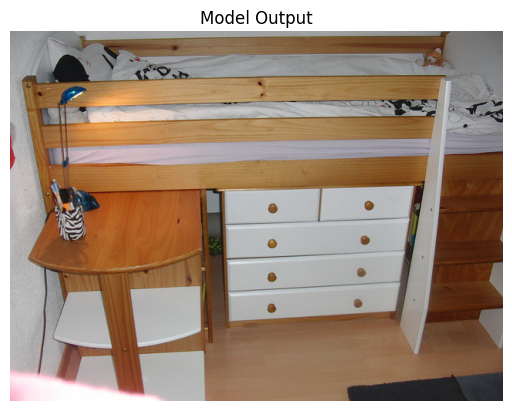

torch.Size([3, 224, 224])


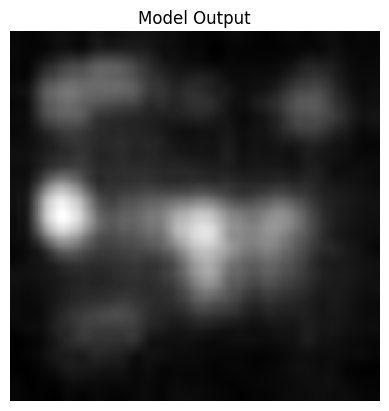

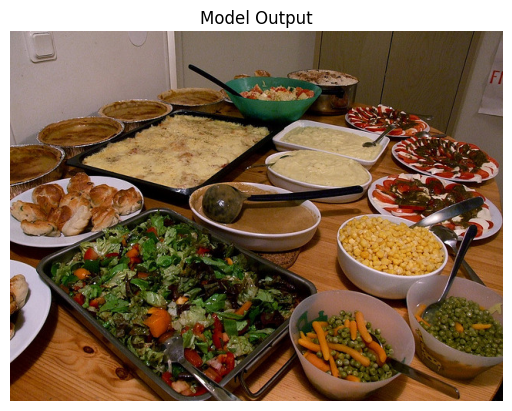

torch.Size([3, 224, 224])


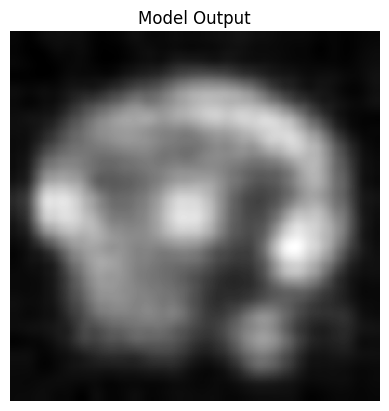

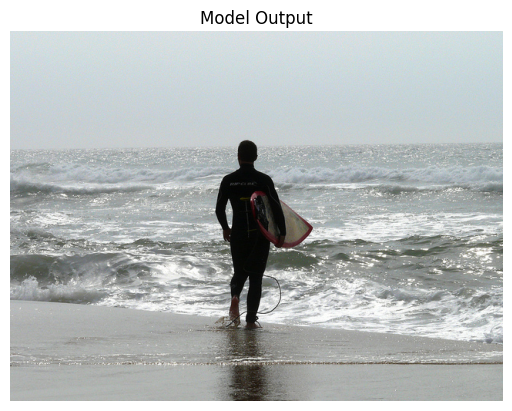

torch.Size([3, 224, 224])


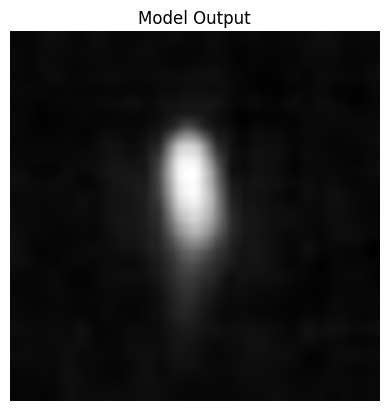

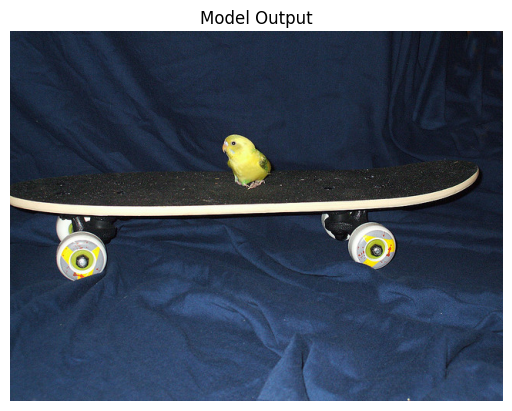

torch.Size([3, 224, 224])


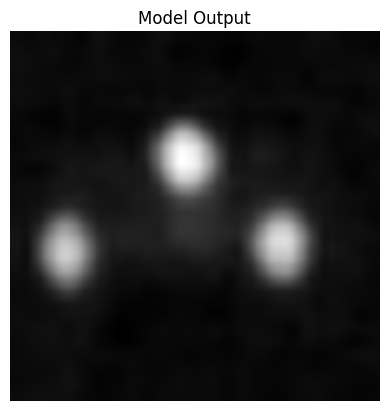

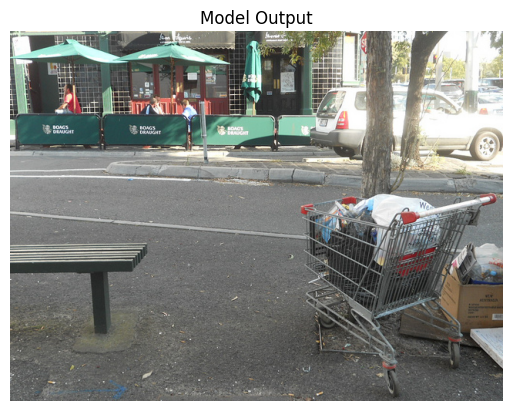

torch.Size([3, 224, 224])


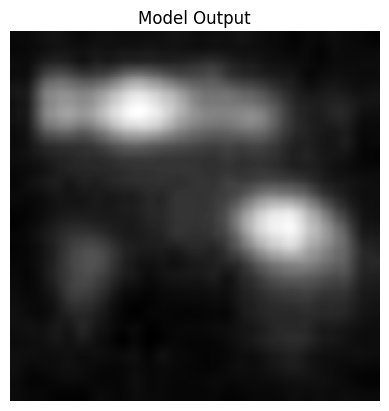

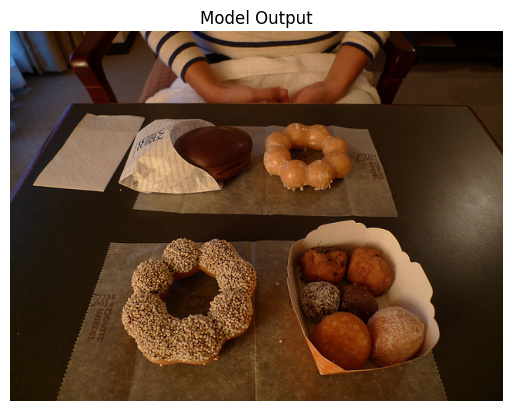

torch.Size([3, 224, 224])


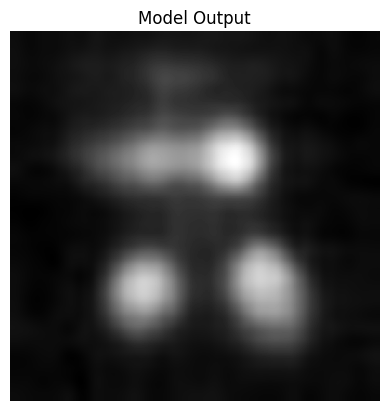

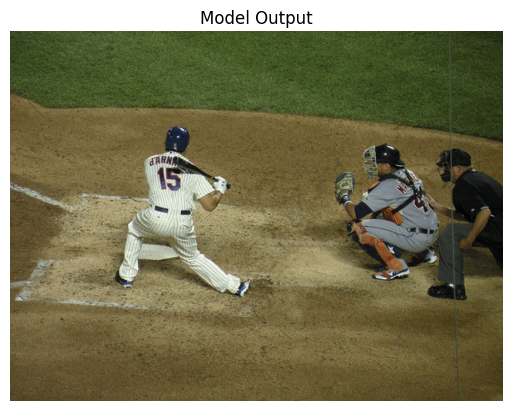

torch.Size([3, 224, 224])


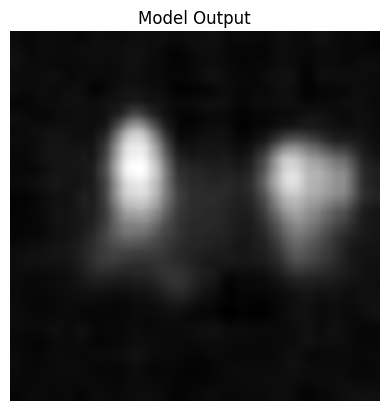

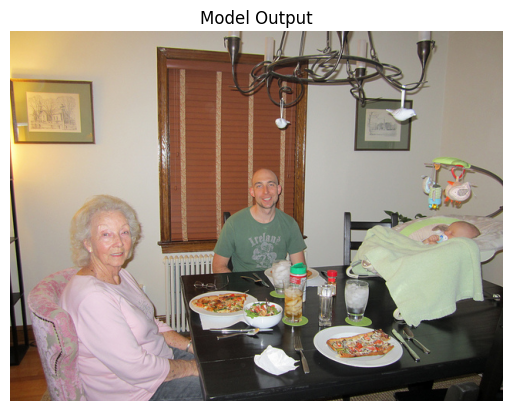

torch.Size([3, 224, 224])


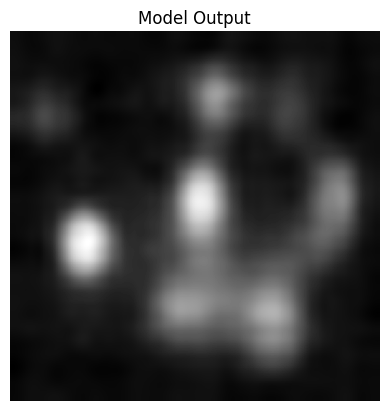

In [35]:
file_name =  ['COCO_val2014_000000000133.jpg', 'COCO_val2014_000000000196.jpg', 'COCO_val2014_000000001369.jpg', 'COCO_val2014_000000001561.jpg', 'COCO_val2014_000000002154.jpg', 'COCO_val2014_000000003001.jpg', 'COCO_val2014_000000005385.jpg', 'COCO_val2014_000000007274.jpg']
trained_model.eval()
val_dir = '/kaggle/input/salicon/images/images/images/val'
save_dir = '/kaggle/working/output_image'
for idx in range(len(file_name)):
        input_img_name = os.path.join(val_dir, file_name[idx])
        input_image = Image.open(input_img_name).convert('RGB')
        plt.imshow(input_image, cmap='gray')
        plt.title('Model Output')
        plt.axis('off')
        plt.show()
        
        input_image = transform(input_image)
        print(input_image.shape)
        input_image = input_image.to(device)
        output_image = trained_model(input_image.expand(1,3,224,224))
        output_image = output_image.cpu().detach().numpy()[0].squeeze()
        output_img_path = os.path.join(save_dir, file_name[idx])
        plt.imsave(output_img_path, output_image)
        plt.imshow(output_image, cmap='gray')
        plt.title('Model Output')
        plt.axis('off')
        plt.show()
        
